# Overview of the Pollen development kit

*Pollen* is an all-digital spiking neural network ASIC, for efficient simulation of spiking leaky integrate-and-fire neurons with exponential input synapses. Pollen is highly configurable, and supports individual synaptic and membrane time-constants, thresholds and biases for each neuron. Pollen supports arbitrary network architectures, including recurrent networks, for up to 1000 neurons.

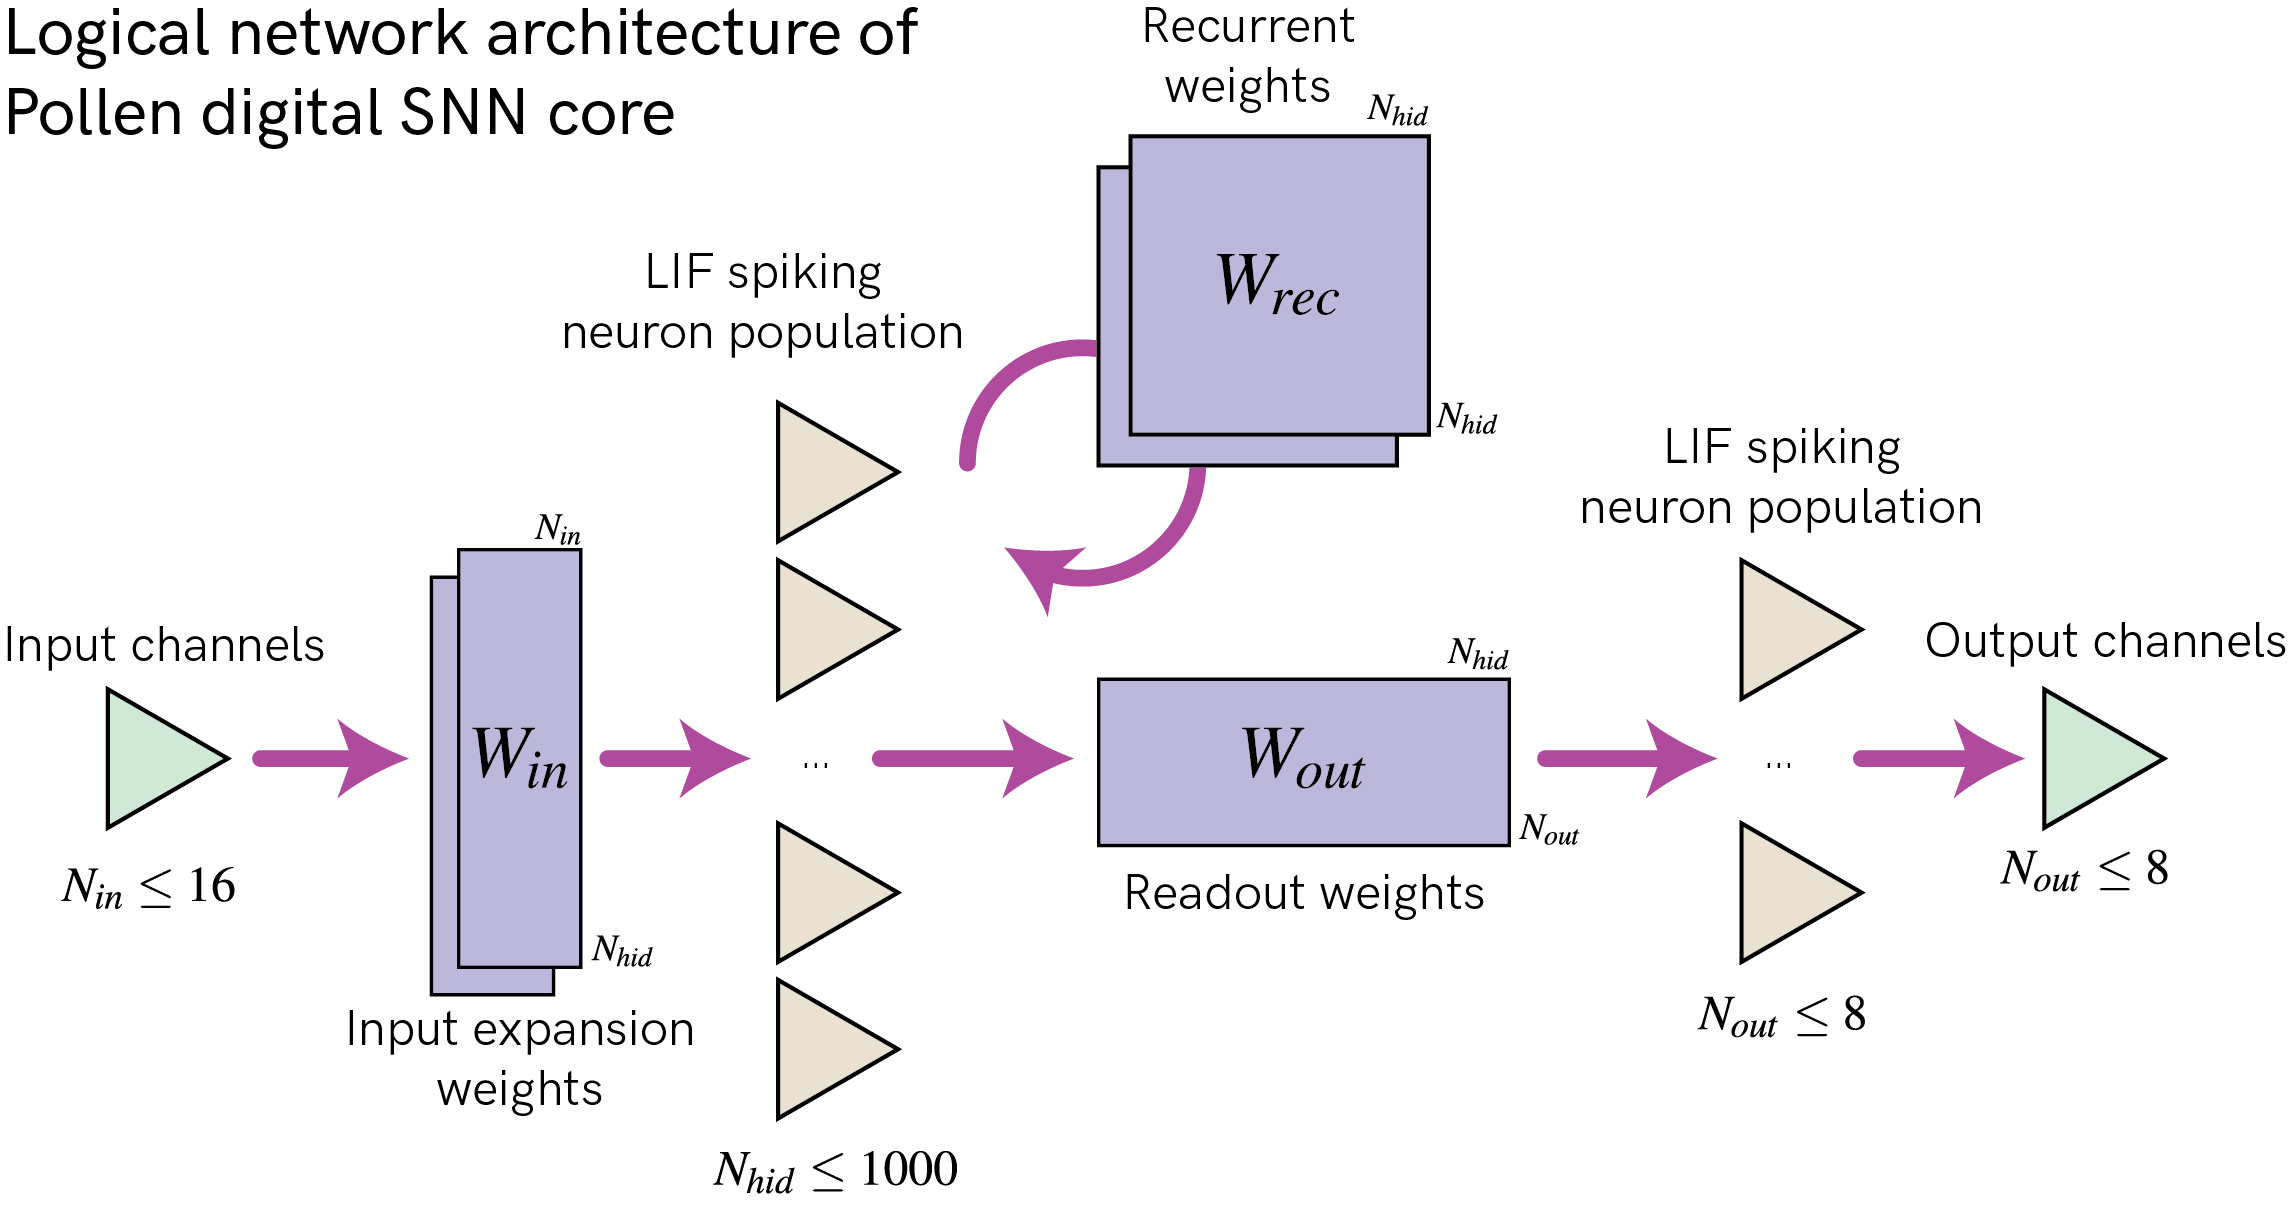

In [1]:
# - Image display
from IPython.display import Image
Image("images/pollen_network-architecture.png")

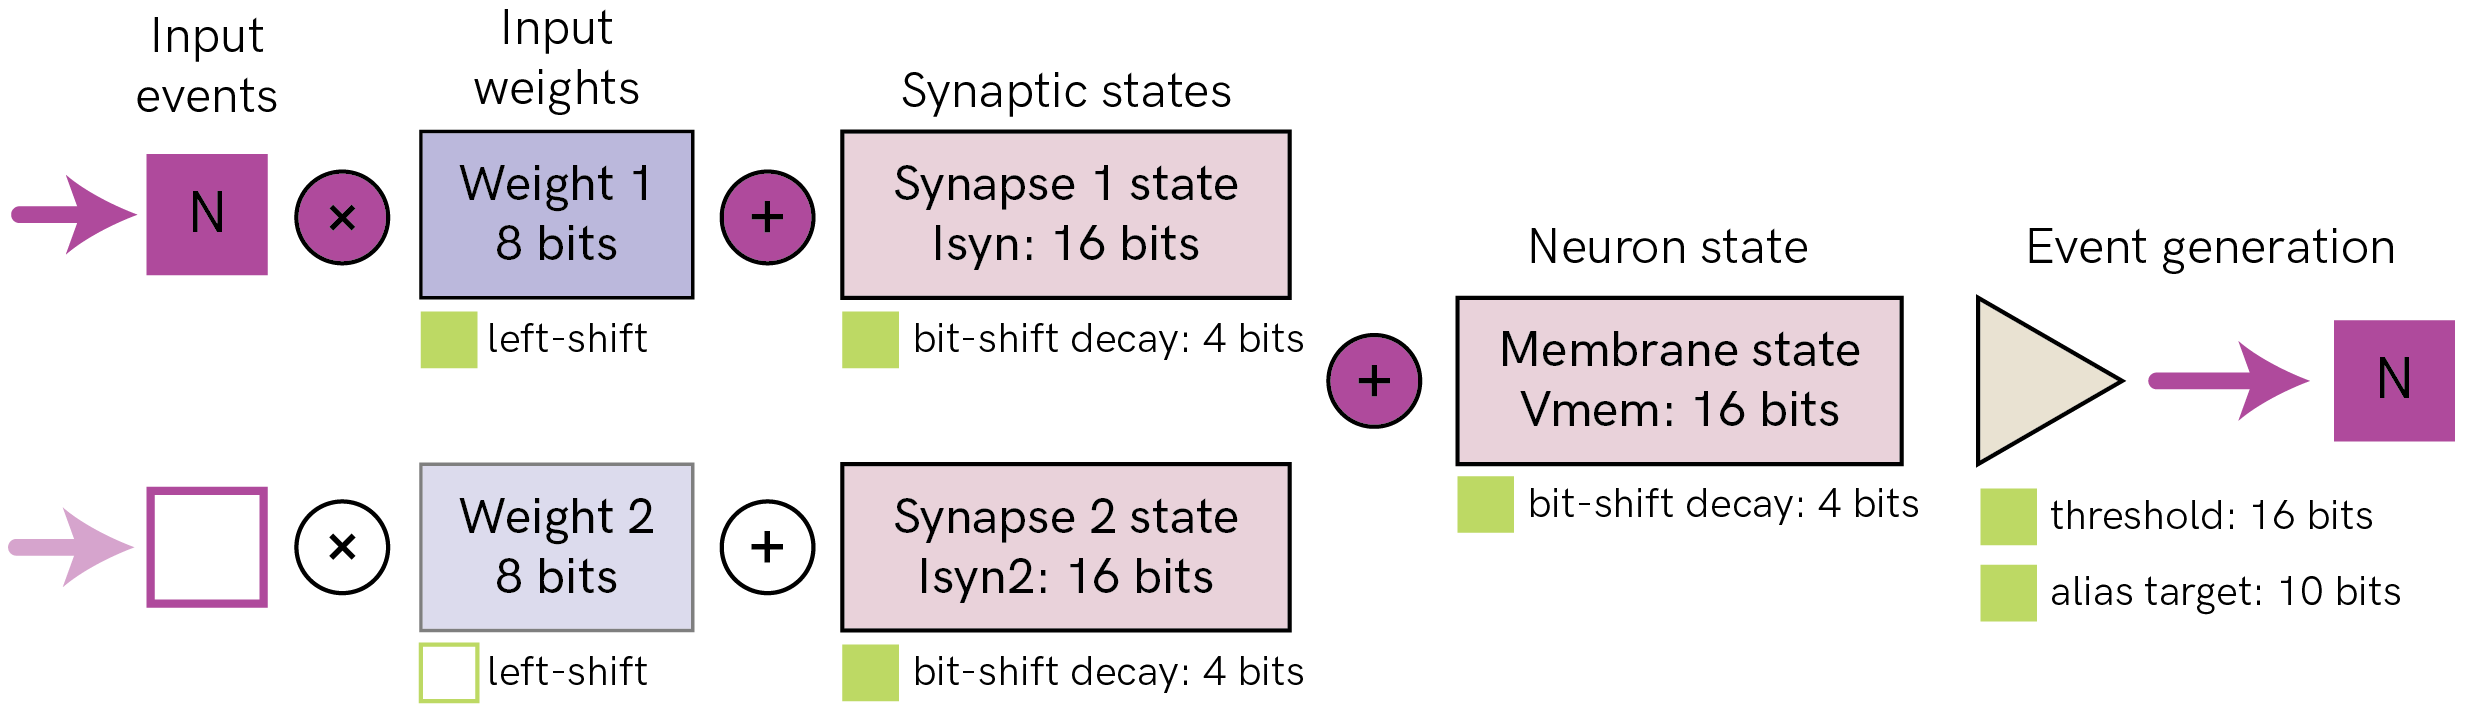

In [2]:
Image("images/pollen_neuron-model.png")

In [3]:
# - Useful imports
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

try:
    from rich import print
except:
    pass

import numpy as np

## Bit-shift decay

Pollen simulates exponential decay using an efficient bit-shift-subtraction technique. Consequently, time constants are expressed as "bit-shift decay" parameters ("dash" parameters) which are a function of the fixed simulation time-step. The equation for that conversion is:

$dash = [\log_2(\tau / dt)]$

Hence, the dash parameter for a synapse with a 2 ms time constant, with a simulation resolution of 1 ms, is ``1``.

But what is done with this bitshift of 1? Let's compare exponential decay with bitshift decay. The bit-shifting decay method is illustrated by the function ``bitshift()`` below.

In [4]:
def bitshift(value: int, dash: int) -> int:
    # - Bit-shift decay
    new_value = value - (value >> dash)

    # - Linear decay below dash-driven change
    if new_value == value:
        new_value -= 1
        
    return new_value

As you can see, the bit-shifting decay is accomplished by the line

$v' = v - (v >> dash)$

where $>>$ is the right-bit-shift operator; $v$ is the current value and $v'$ is the new value after the bit-shifting step. Since $v$ is an integer, for low values of $v$, $v >> dash = 0$. We therefore perform a linear decay for low values of $v$.

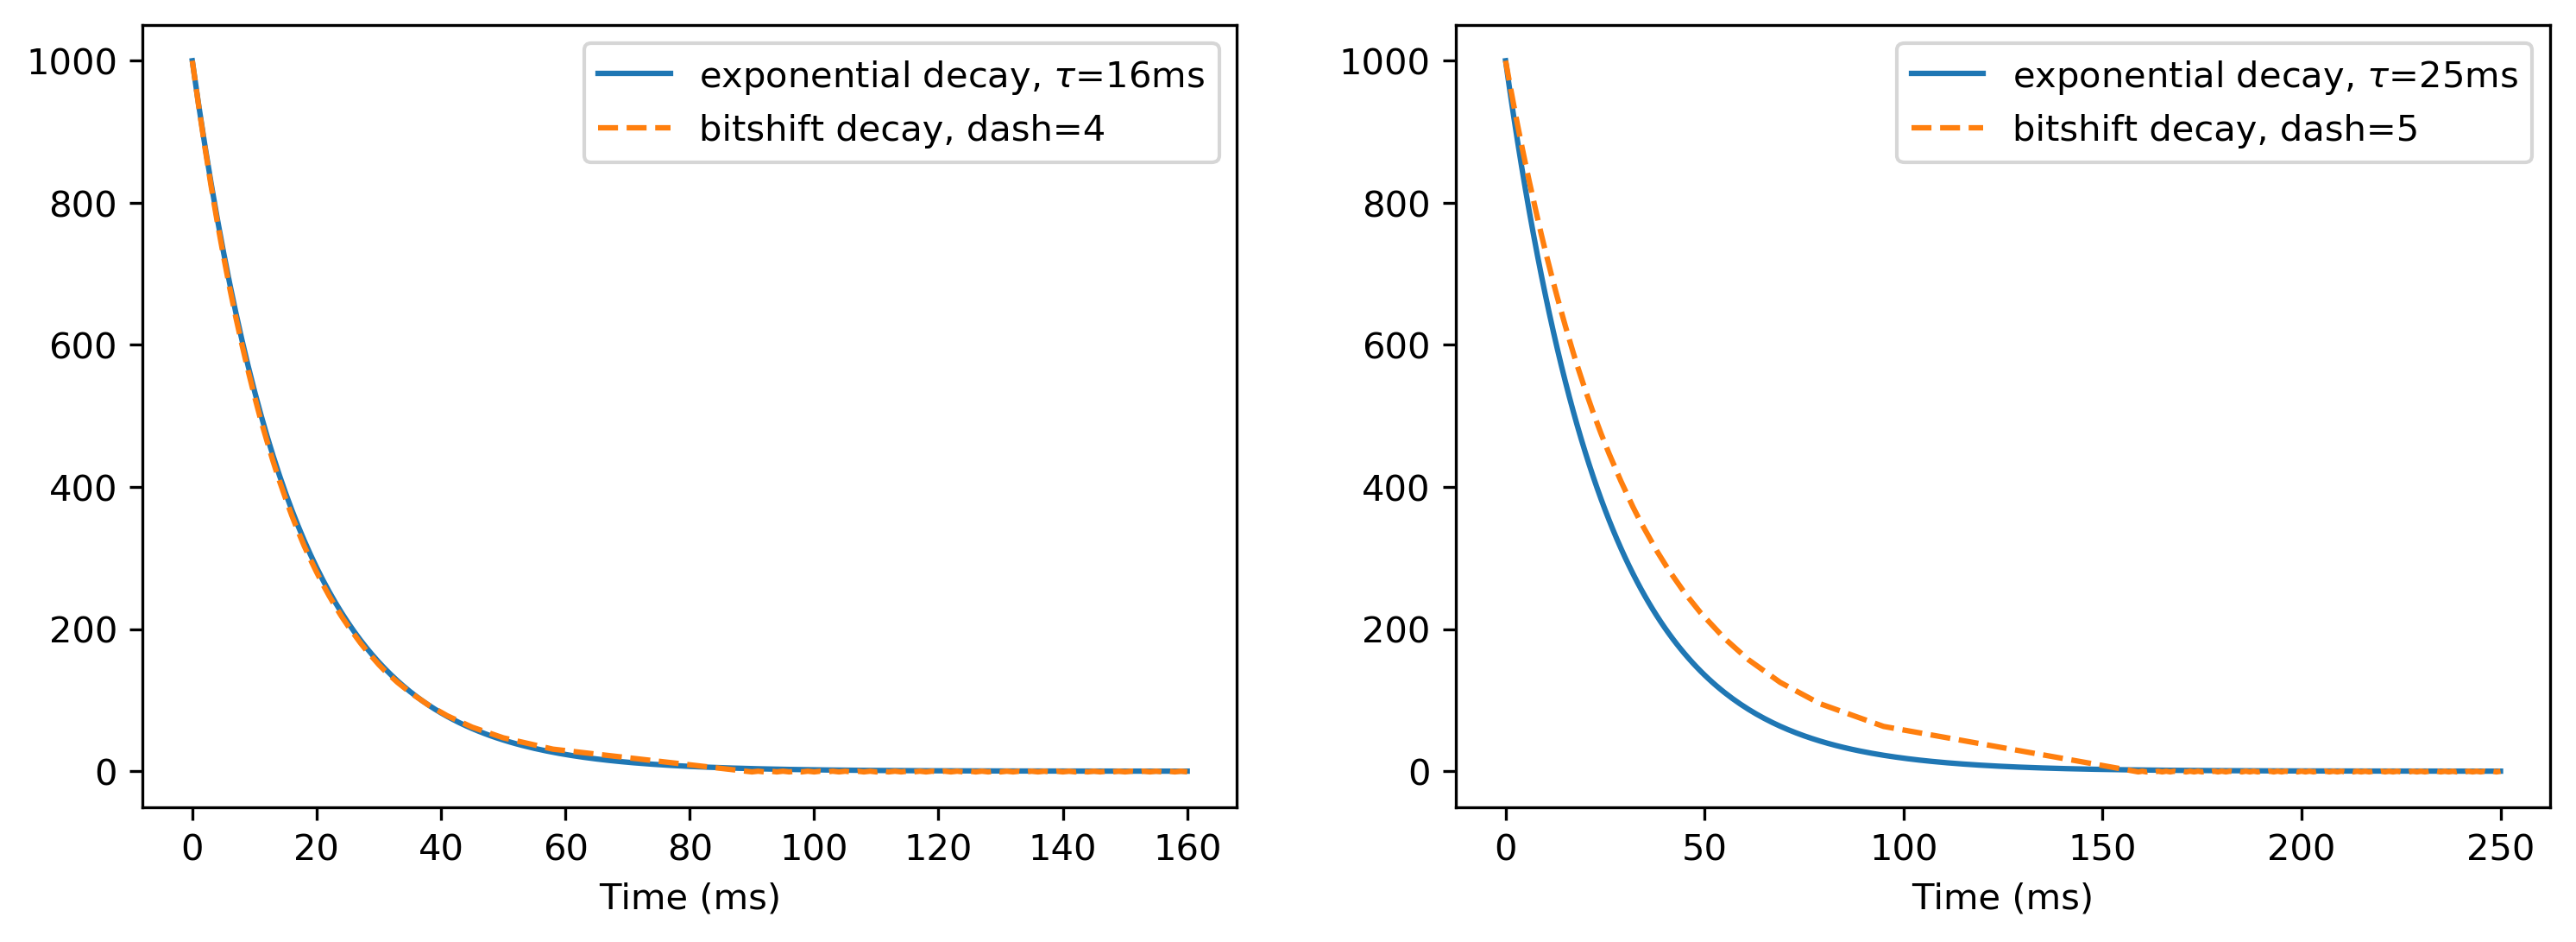

In [5]:
def plot_tau_dash(tau: float, dt_: float = 1e-3, simtime: float = None):
    if simtime is None:
        simtime = tau * 10.
    
    # - Compute dash, and the exponential propagator per time-step
    dash = np.round(np.log2(tau / dt_)).astype(int)
    exp_propagator = np.exp(-dt_ / tau)

    # - Compute exponential and dash decay curves over time
    t_ = 0
    v_tau = [1000]
    v_dash = [1000]
    while t_ < simtime:
        v_tau.append(v_tau[-1] * exp_propagator)    
        v_dash.append(bitshift(v_dash[-1], dash))
        t_ += dt_

    # - Plot the two curves for comparison
    plt.plot(np.arange(0, len(v_tau)) * dt_ * 1e3, v_tau, label = f'exponential decay, $\\tau$={int(tau * 1e3)}ms')
    plt.plot(np.arange(0, len(v_dash)) * dt_ * 1e3, v_dash, '--', label = f'bitshift decay, dash={dash}')
    plt.legend()
    plt.xlabel("Time (ms)");

# - Plot examples for tau = 16ms and tau = 25 ms
plt.figure();
plt.subplot(1, 2, 1);
plot_tau_dash(16e-3)

plt.subplot(1, 2, 2);
plot_tau_dash(25e-3)

For powers of two, the approximation is very close. But since this is integer arithmetic, the approximation will not always be perfect. We can see this with the example of $\tau = 25$ms.

## Setting up a Pollen simulation

In [6]:
# - Rockpool imports
from rockpool.devices import pollen
from rockpool import TSContinuous, TSEvent

/Users/Shared/anaconda3/envs/py36_tf/lib/python3.6/site-packages/samna
finished bindings


In [7]:
# - Define a network
dt = 1e-3
Nin = 1
Nhidden = 1
Nout = 1

# - Build a Pollen simulation module from a specification
config, _, _ = pollen.config_from_specification(
    weights_in = 127 * np.ones((Nin, Nhidden, 2), 'int'),
    weights_out = 127 * np.ones((Nhidden, Nout), 'int'),
    dash_syn = 4 * np.ones(Nhidden, 'int'),
    dash_mem = 4 * np.ones(Nhidden, 'int'),
    dash_mem_out = 4 * np.ones(Nout, 'int'),
    threshold = 1800 * np.ones(Nhidden, 'int'),
    threshold_out = 150 * np.ones(Nhidden, 'int'),
)
mod_cimulator = pollen.PollenCim.from_config(config, dt = dt).timed()
print(mod_cimulator)

In [8]:
# - Simulate the evolution of the network on Pollen
T = 1000
input_rate = 0.05
input_ts = TSEvent.from_raster(np.random.rand(T, Nin) < input_rate, dt = dt, name = 'Input events')

# - Simulate evolution and record internal state
output_events, _, rec_state = mod_cimulator(input_ts, record = True)

WARNING    /Users/dylan/aiCTX Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/timeseries.py:2410: UserWarning: TSEvent `Input events` is not defined for some of the channels provided in `channels` argument (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15). Will assume that there are no events for these channels.
  + f"Will assume that there are no events for these channels."
 [py.warnings]


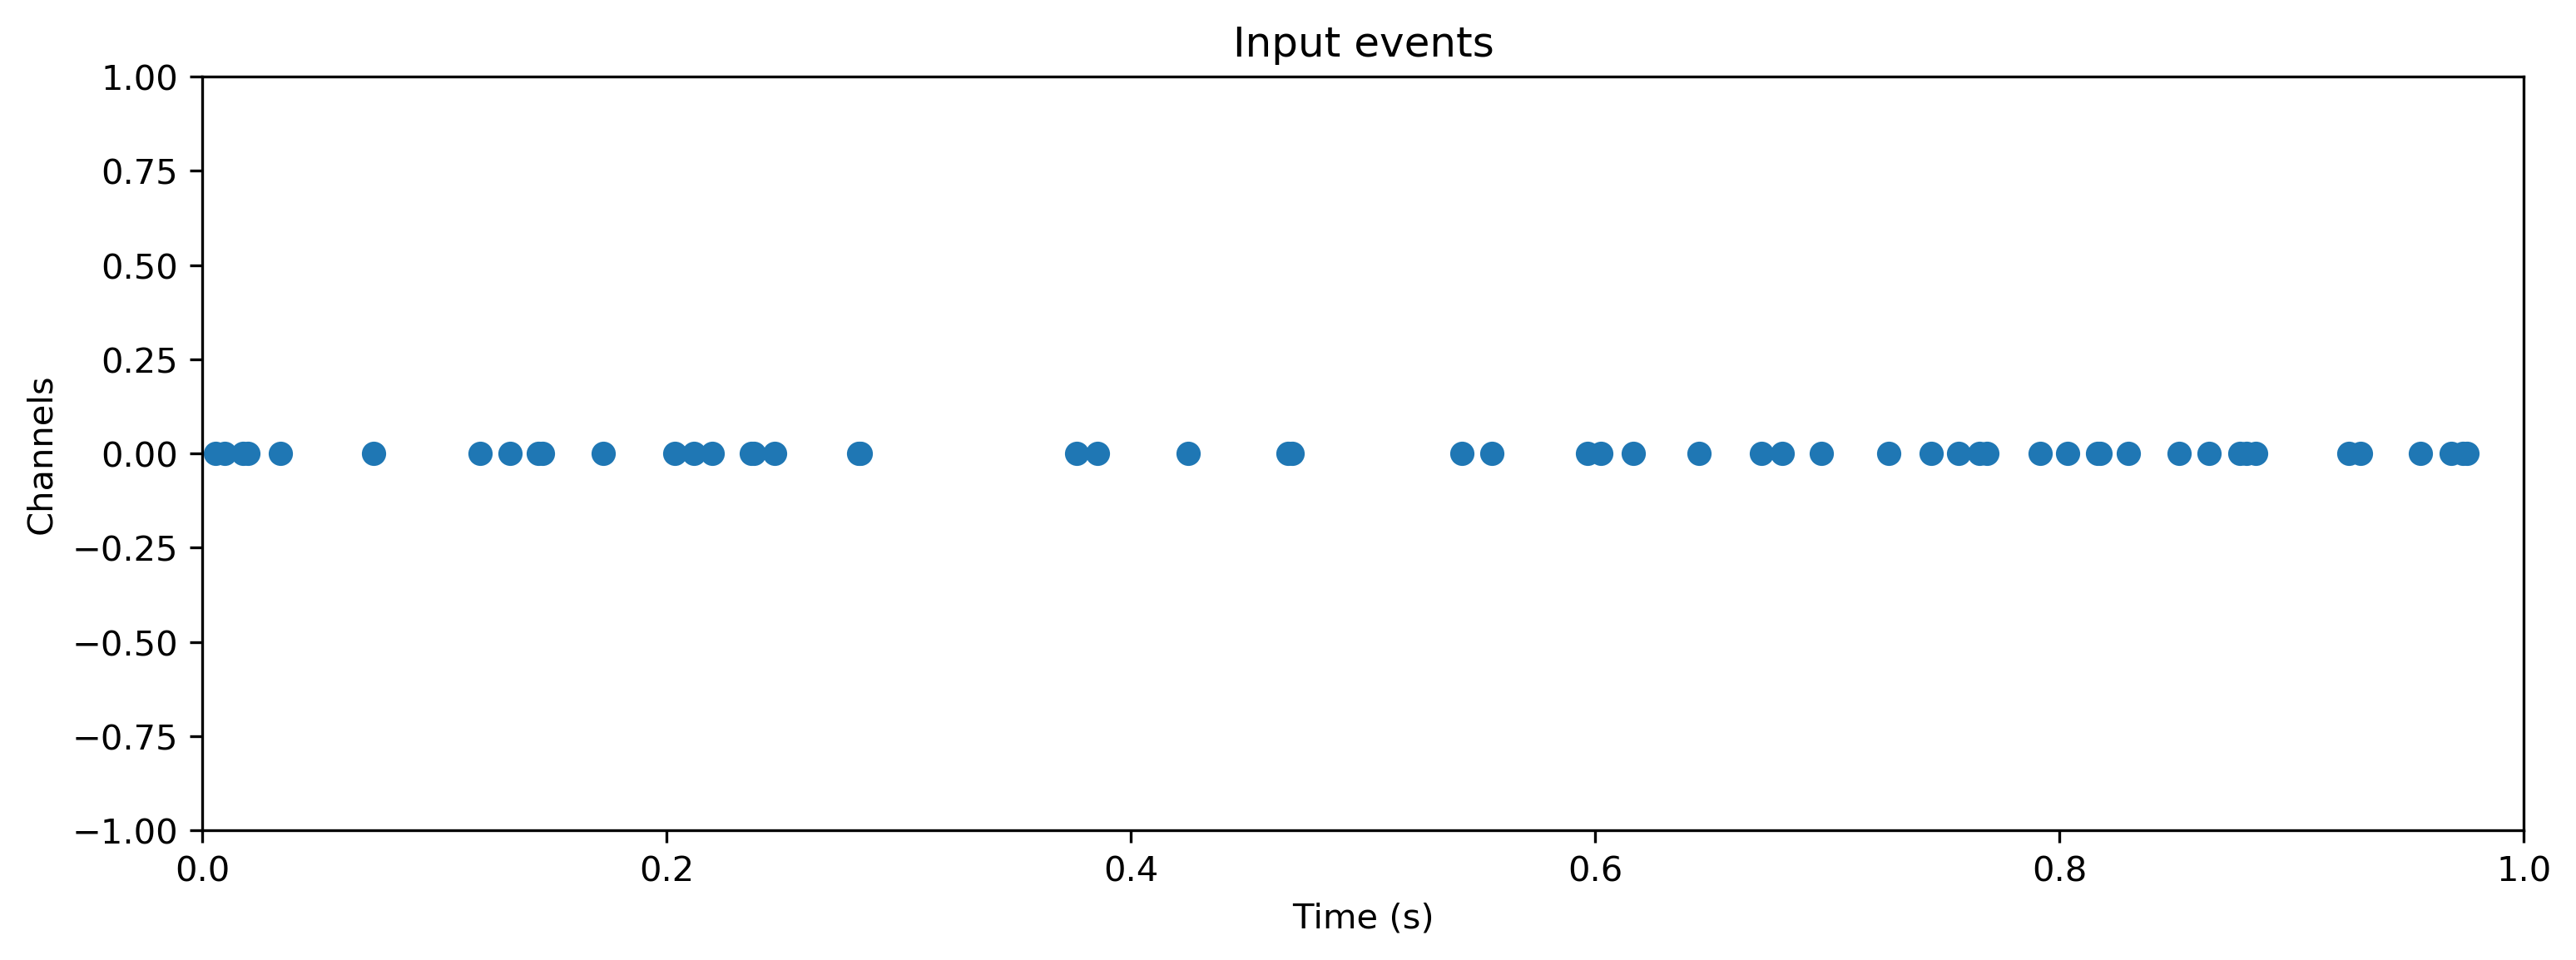

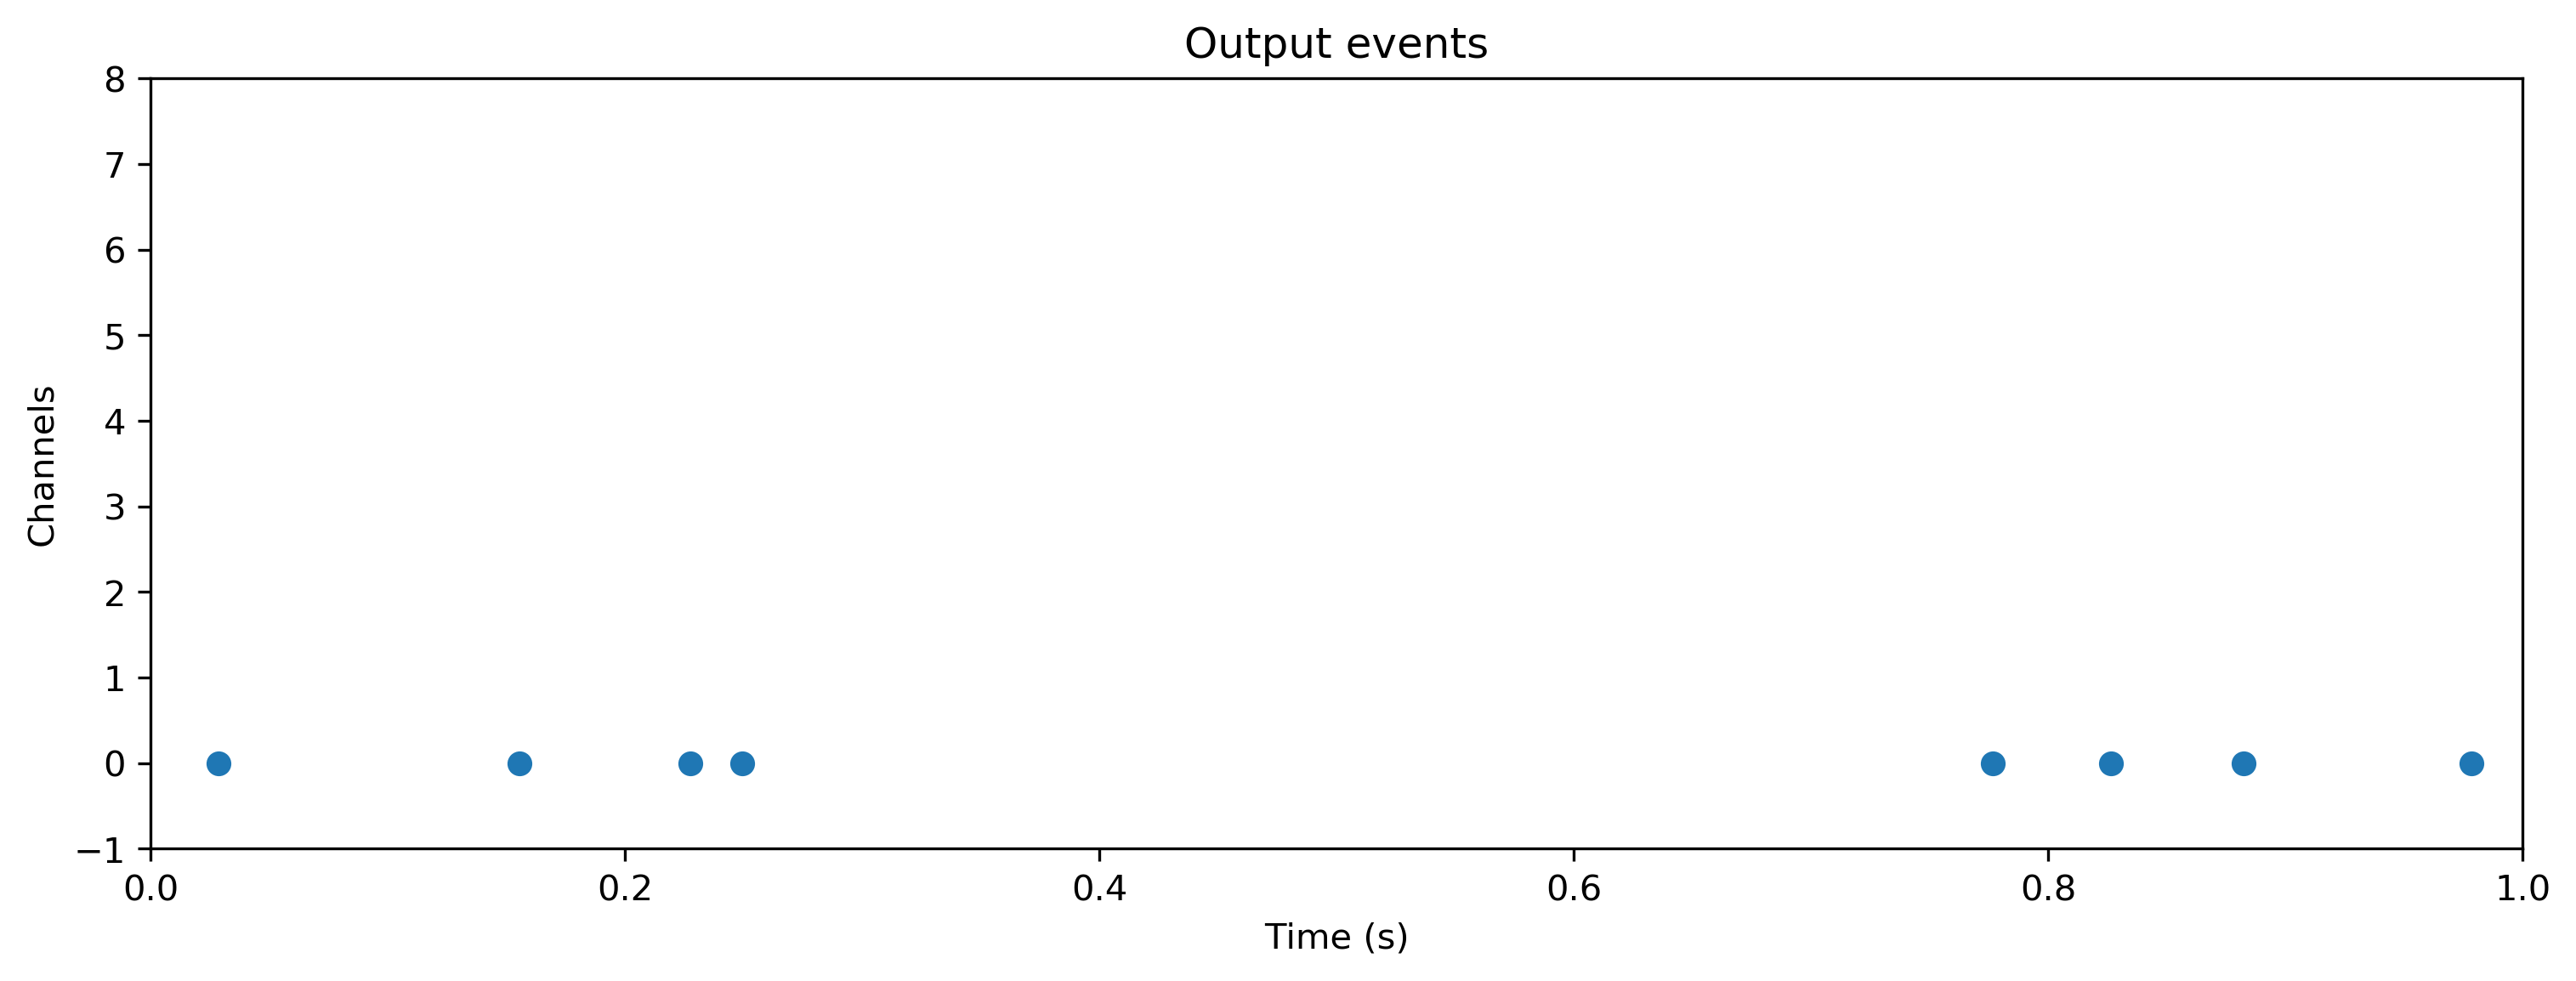

In [9]:
# - Plot the input and output
input_ts.plot();
plt.figure();
output_events.plot();

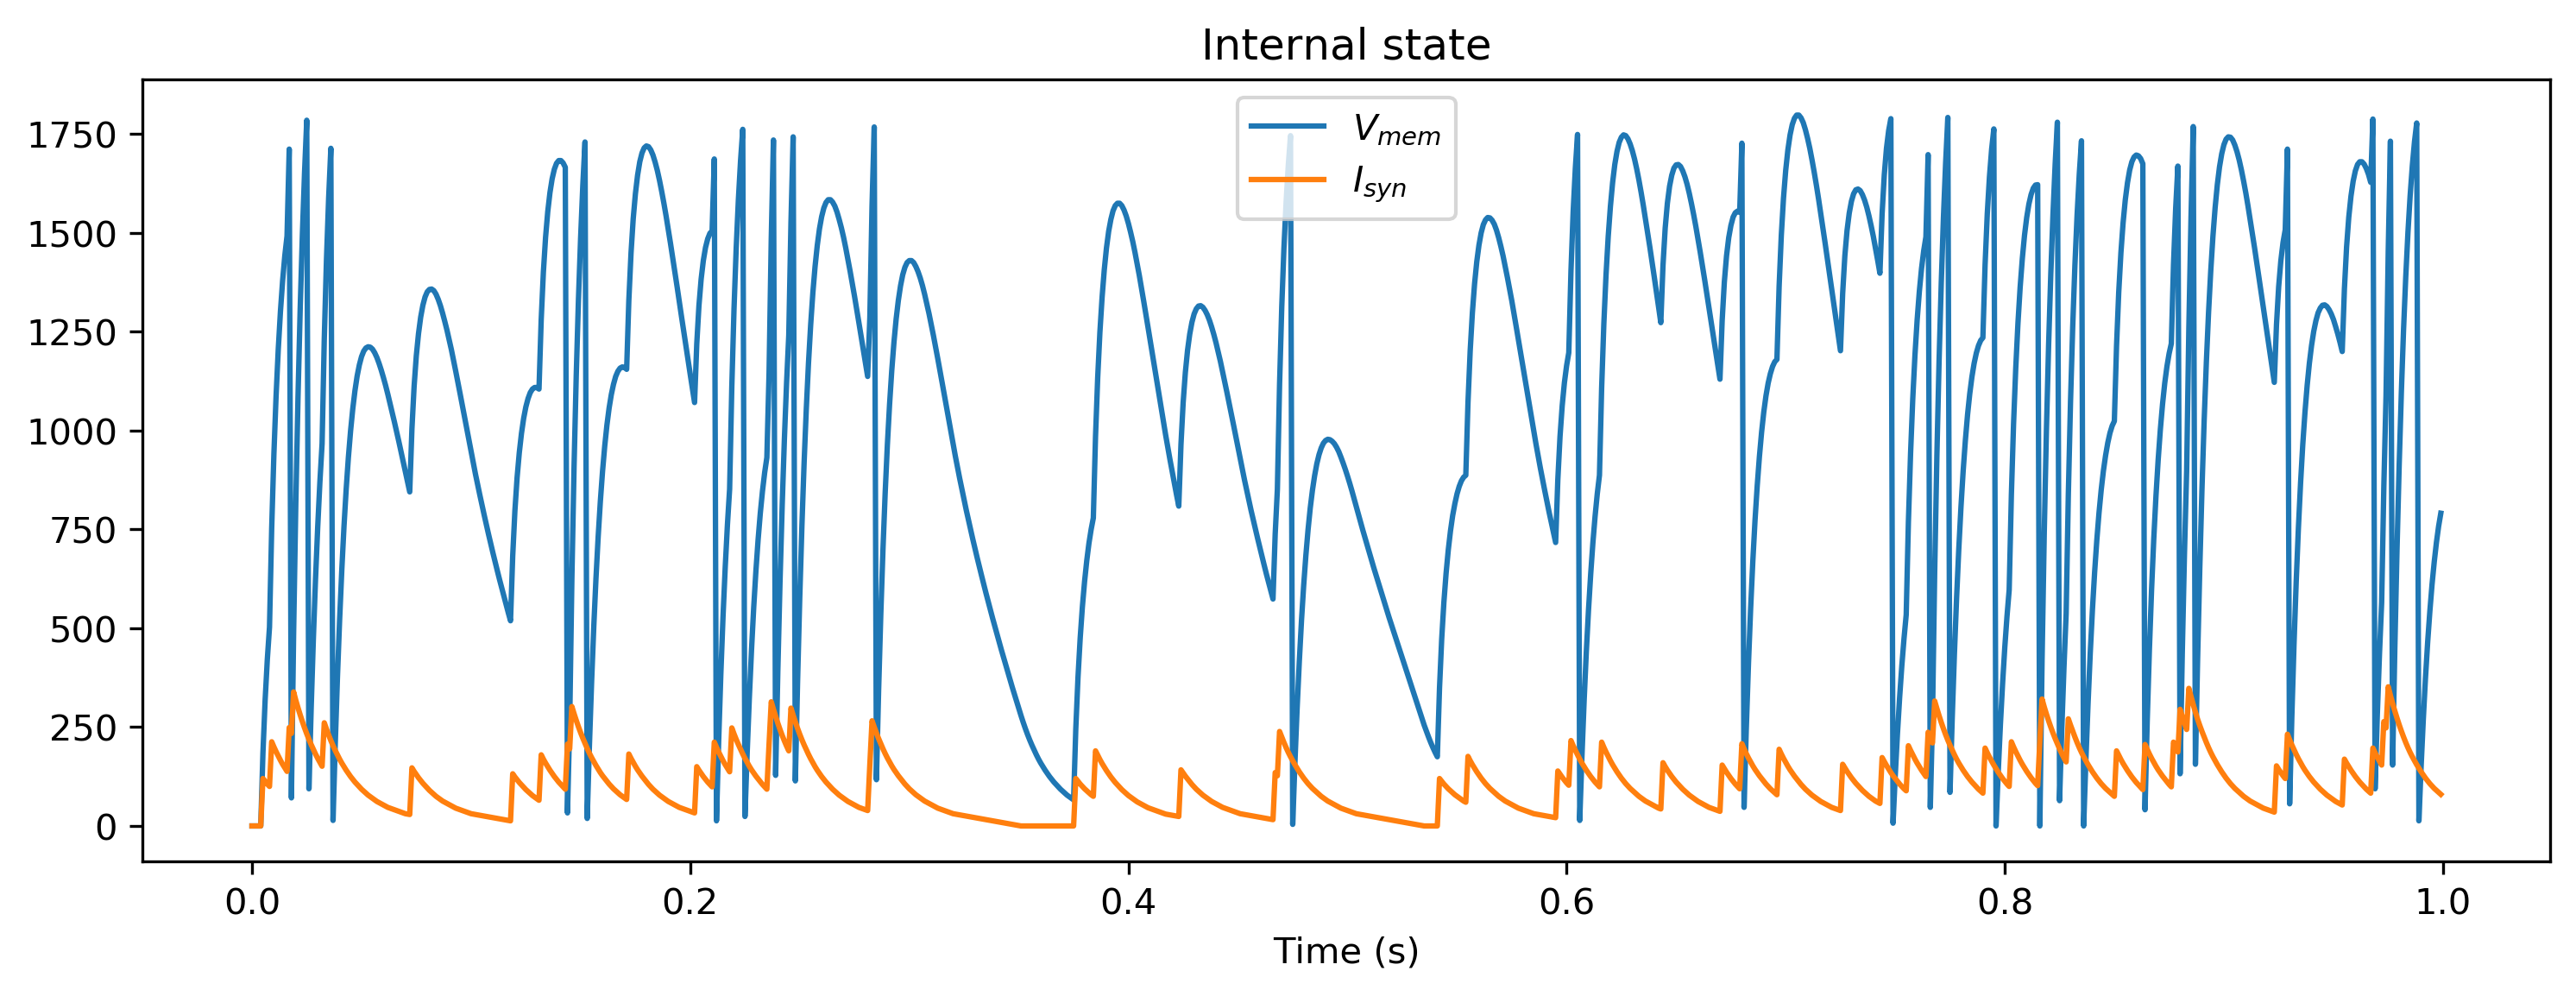

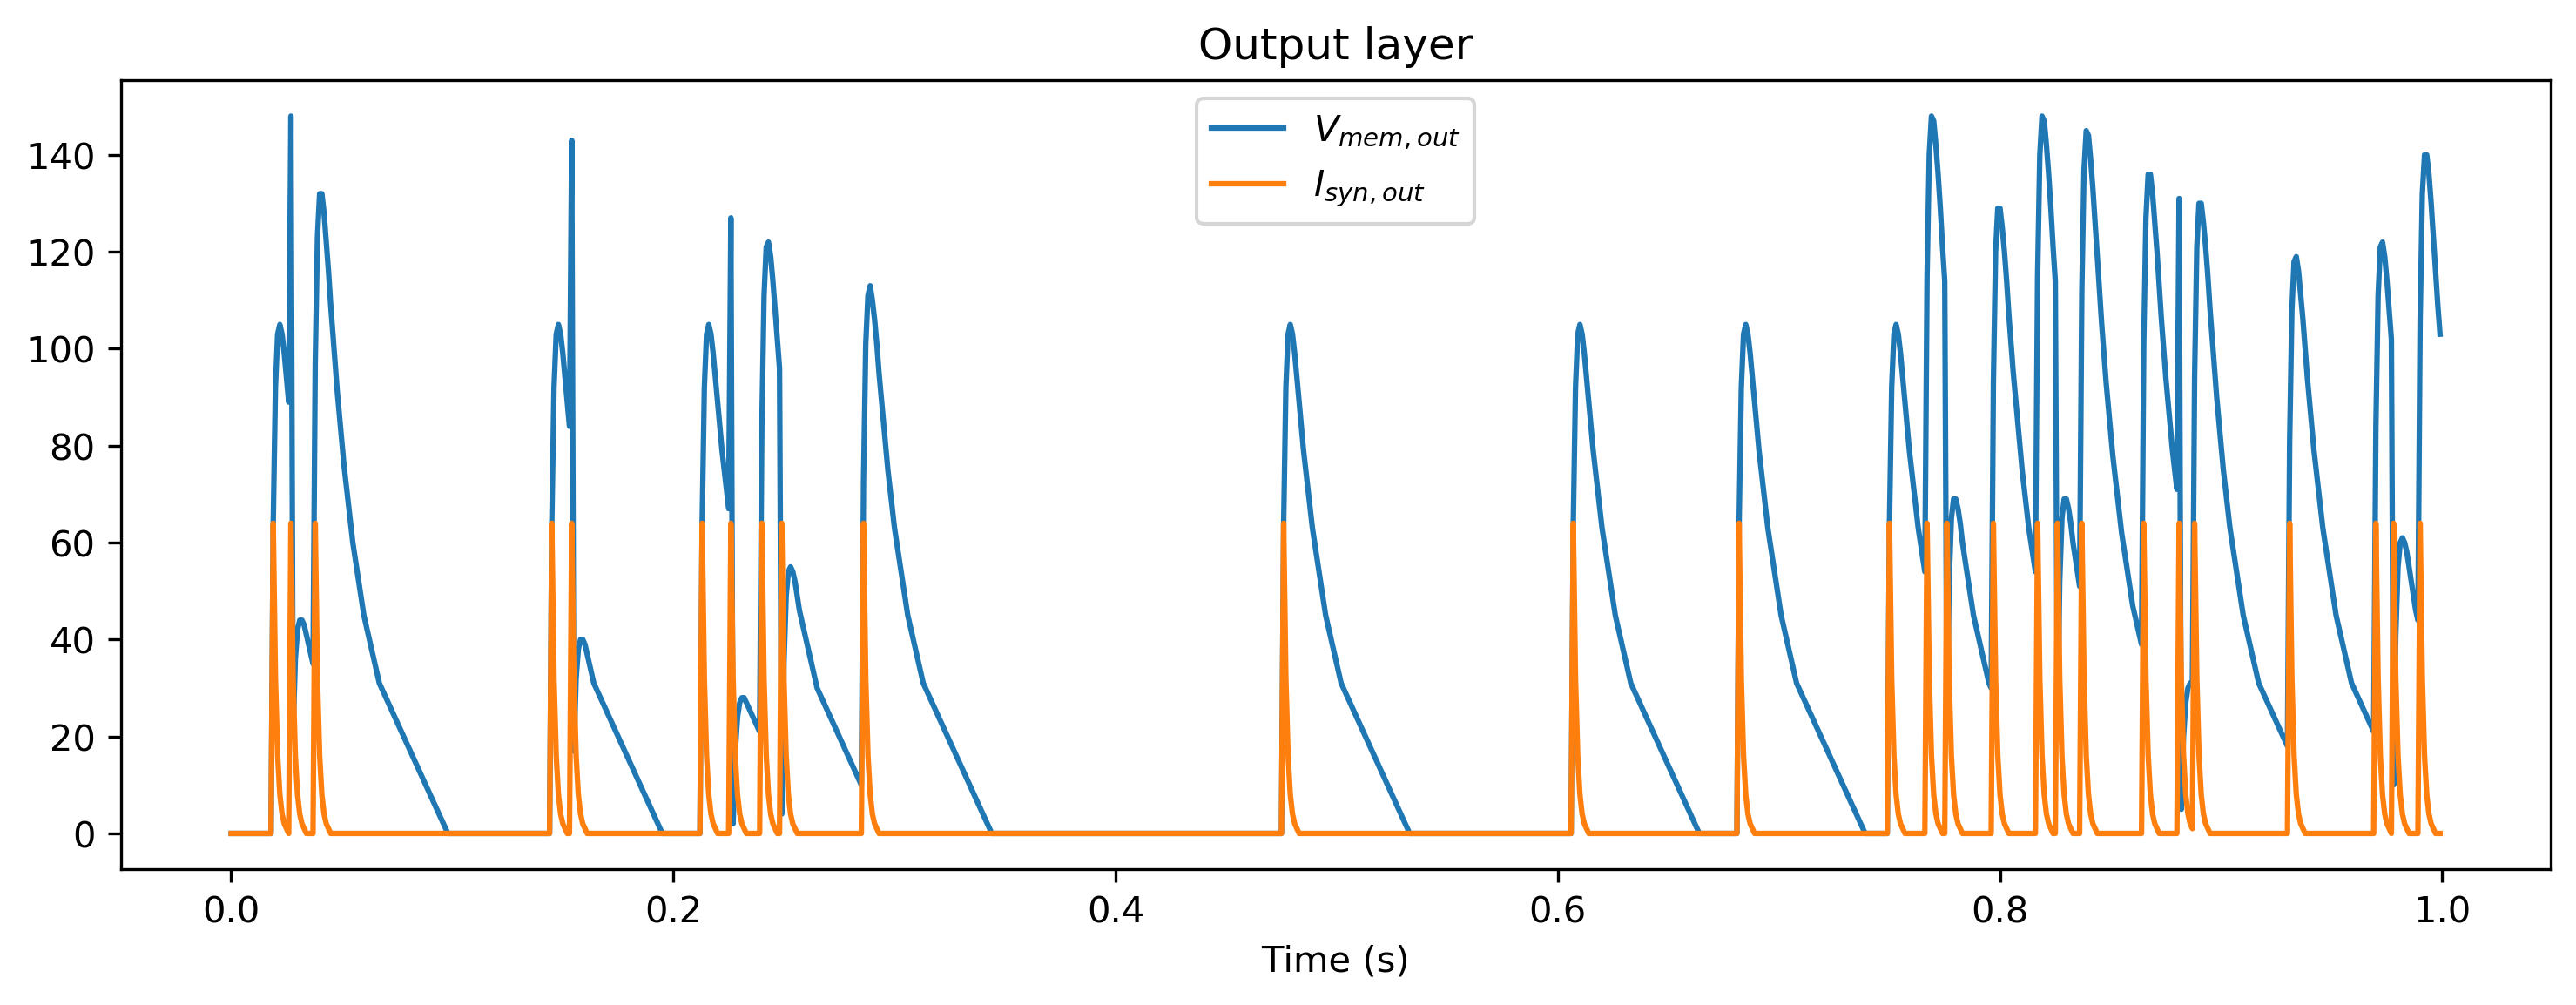

In [10]:
# - Display the internal state
print('Available state traces:', rec_state.keys())

TSContinuous.from_clocked(rec_state['Vmem'], dt = dt, name = '$V_{mem}$').plot()
TSContinuous.from_clocked(rec_state['Isyn'], dt = dt, name = '$I_{syn}$').plot()
plt.title('Internal state')
plt.legend();

plt.figure()
TSContinuous.from_clocked(rec_state['Vmem_out'], dt = dt, name = '$V_{mem, out}$').plot()
TSContinuous.from_clocked(rec_state['Isyn_out'], dt = dt, name = '$I_{syn, out}$').plot()
plt.title('Output layer')
plt.legend();

## Moving a network to HW

Now we need to move this network on to the Pollen development kit hardware. As an interface we need the ``samna`` python package, which can be installed using ``pip install samna``.

### Create a local Samna node

We must first create a local ``samna`` node to host the board (this is simply following the ``samna`` tutorials).

In [11]:
# - Samna
import samna

# receiver and sender endpoints for the local nodes
# Use any free port number instead of 33378
receiver_endpoint = "tcp://0.0.0.0:31378"
sender_endpoint = "tcp://0.0.0.0:31379"

# Every node must have a unique ID
node_id = 1
interpreter_id = 2

# Construct the device node from Python. To interact with it we will
# later need to connect to it as if it was a remote node.
samna_node = samna.SamnaNode(sender_endpoint, receiver_endpoint, node_id)

# Make a local node that can be interacted with from Python
samna.setup_local_node(receiver_endpoint, sender_endpoint, interpreter_id)

# Open the samna_node we first constructed as a remote node and give it the
# name "device_node".
# The contents of the node are now available as the Python submodule samna.device_node
samna.open_remote_node(node_id, "device_node")

### Open a dev kit device

In [12]:
from rockpool.devices.pollen import PollenSamna
import rockpool.devices.pollen.pollen_devkit_utils as putils

# - Find a Pollen HDK daughterboard, and use the first one
pollen_hdk_nodes = putils.find_pollen_boards(samna.device_node)
daughterboard = pollen_hdk_nodes[0]

In [13]:
# - Create a Rockpool module to manage the dev kit
#   Copy the configuration directly from the Cimulator module
mod_pollen = PollenSamna(daughterboard, config, dt).timed()
print(mod_pollen)

WARNING    /Users/dylan/aiCTX Dropbox/Dylan Muir/LiveSync/Development/rockpool_GIT/rockpool/devices/pollen/pollen_devkit_utils.py:429: UserWarning: DYLAN ADD A TIMEOUT HERE
  warn("DYLAN ADD A TIMEOUT HERE")
 [py.warnings]


### Evolve the network and display state over time

In [14]:
# - Evolve the network on the Pollen dev kit and record the internal state
mod_pollen.reset_all()
output_ts, _, rec_state_hdk = mod_pollen(input_ts, record = True)

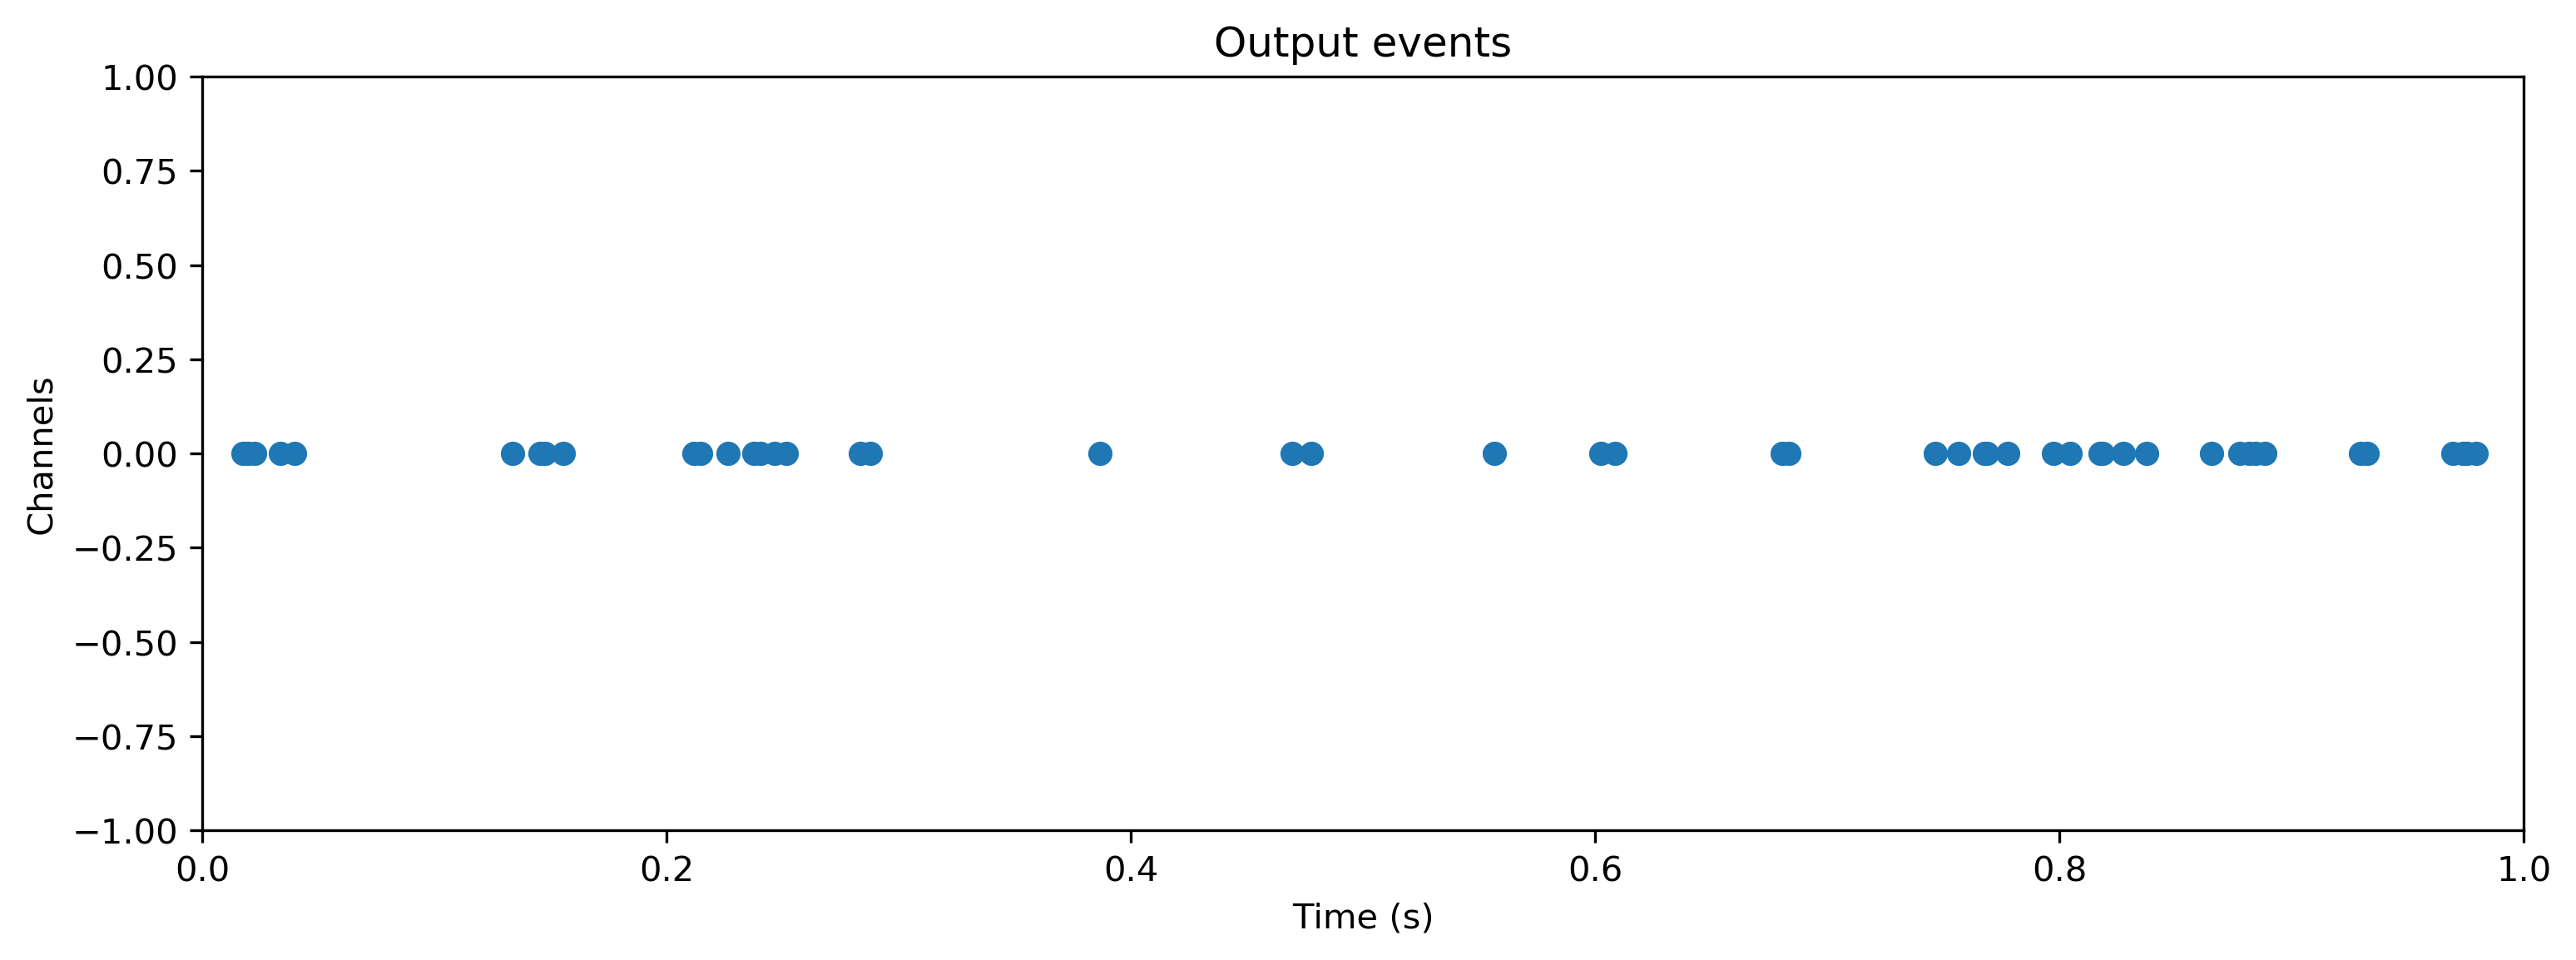

In [15]:
# - Plot the output activity
output_ts.plot();

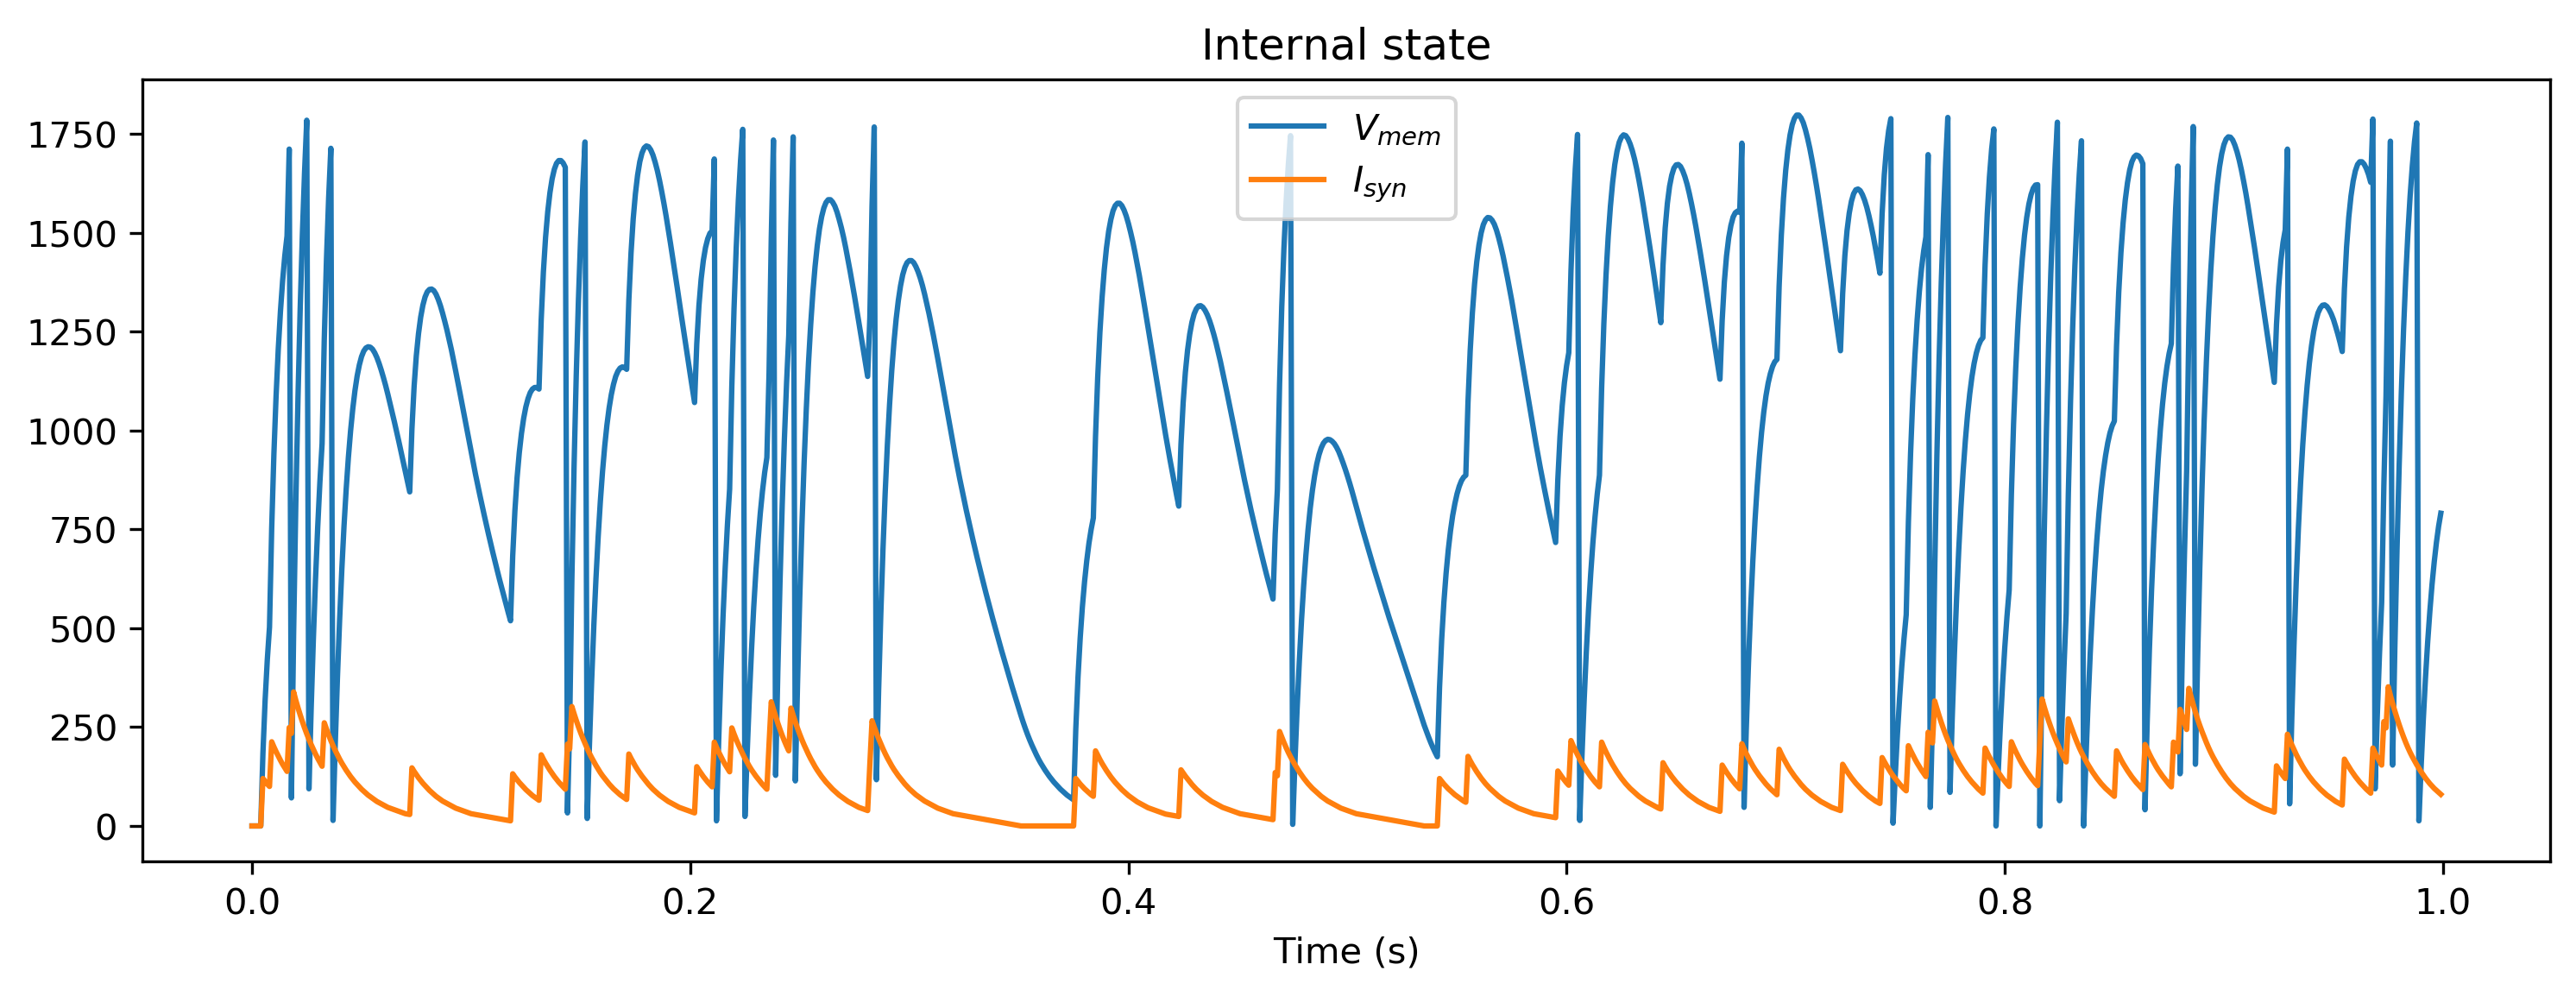

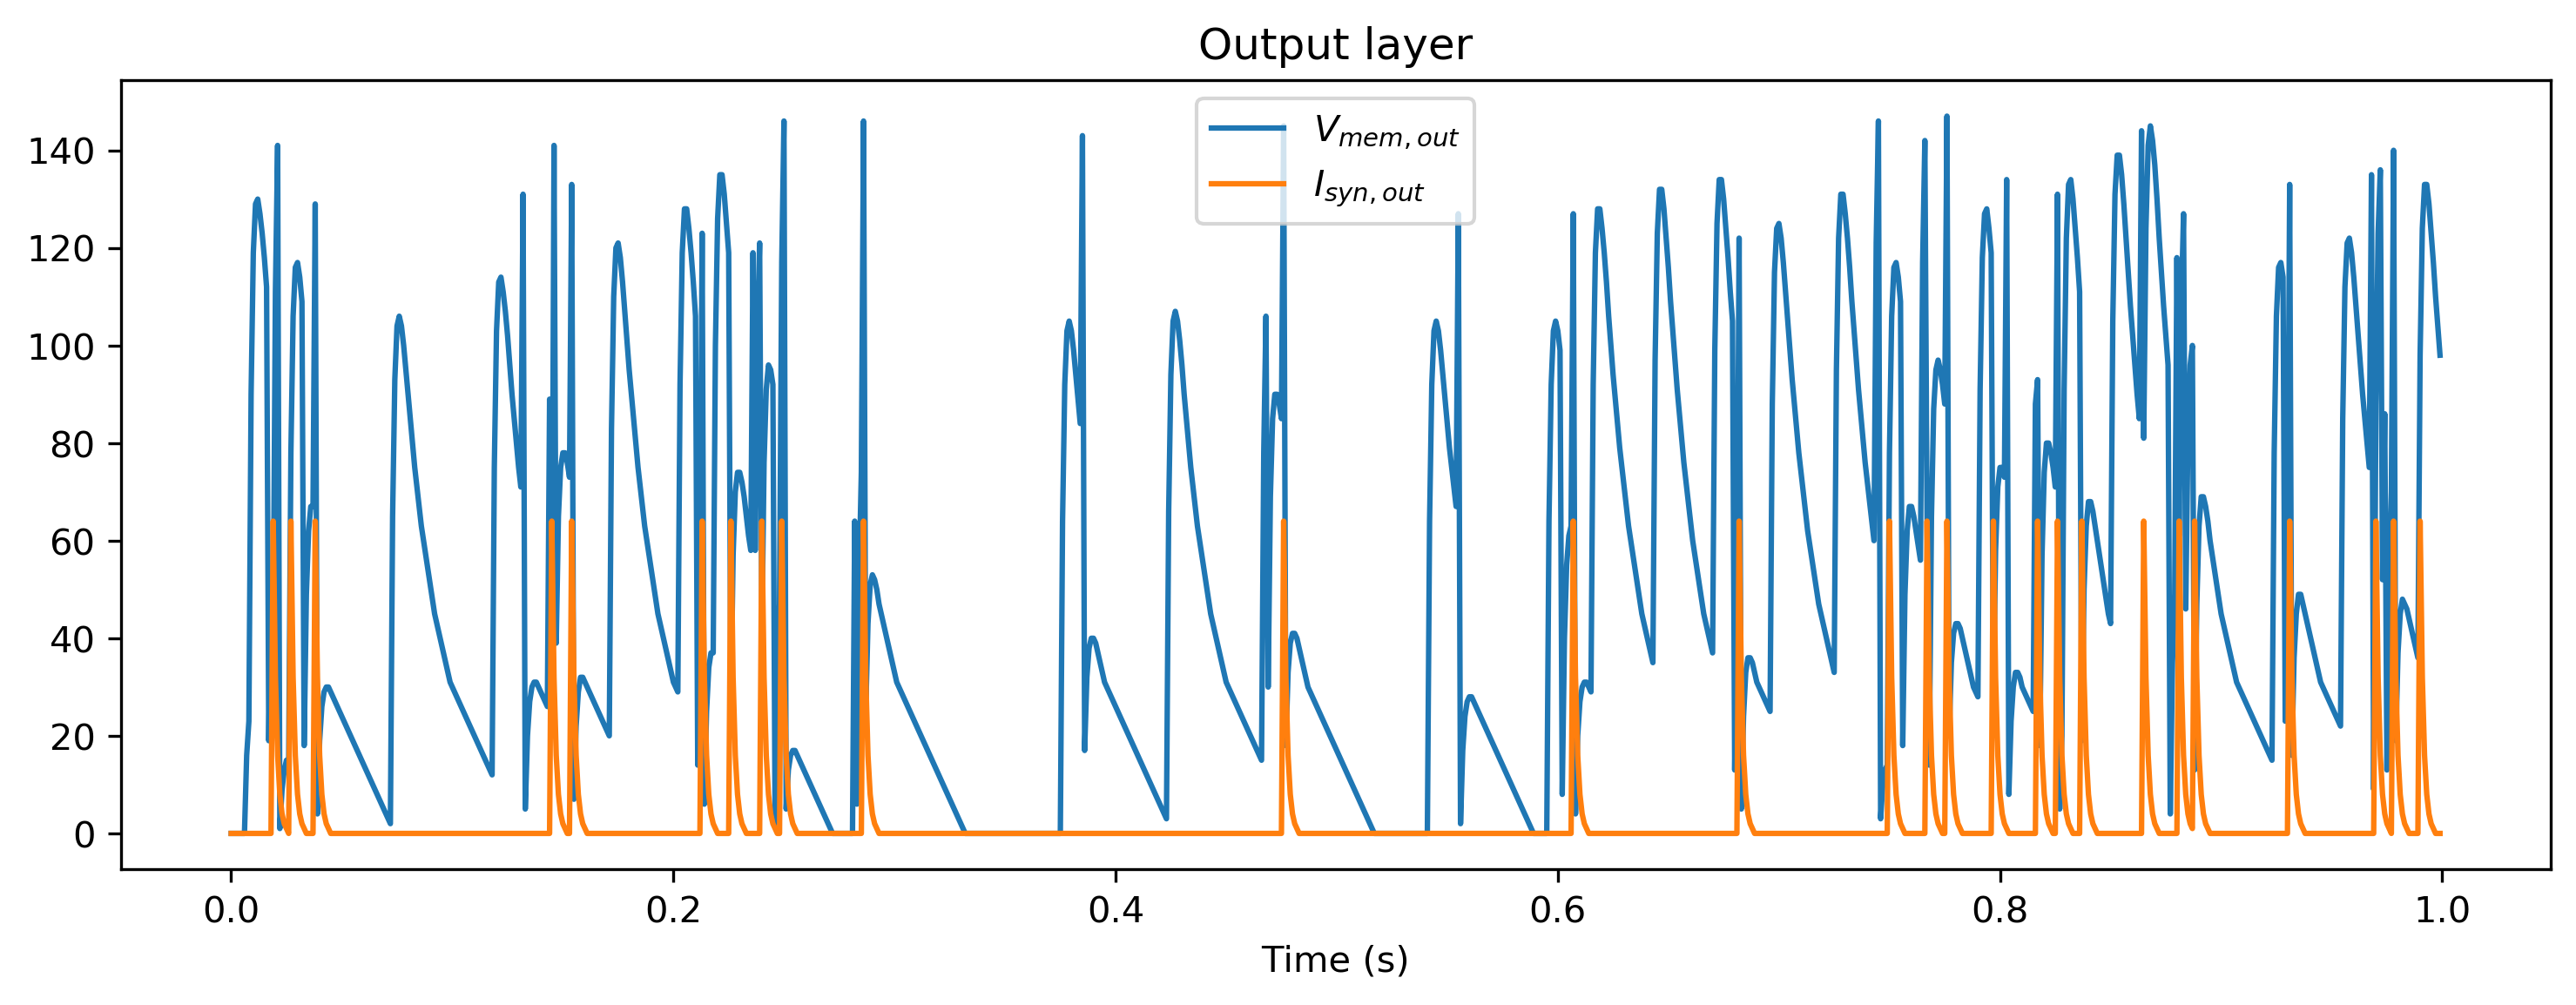

In [16]:
# - Display the internal state
print('Available state traces:', rec_state_hdk.keys())

TSContinuous.from_clocked(rec_state_hdk['Vmem'], dt = dt, name = '$V_{mem}$').plot()
TSContinuous.from_clocked(rec_state_hdk['Isyn'], dt = dt, name = '$I_{syn}$').plot()
plt.title('Internal state')
plt.legend();

plt.figure()
TSContinuous.from_clocked(rec_state_hdk['Vmem_out'], dt = dt, name = '$V_{mem, out}$').plot()
TSContinuous.from_clocked(rec_state_hdk['Isyn_out'], dt = dt, name = '$I_{syn, out}$').plot()
plt.title('Output layer')
plt.legend();